In [1]:
import logging

import numpy as np
import probtorch
import torch

import bouncing_ball
import bouncing_ball_data
import combinators
import importance
import utils

In [2]:
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection

import matplotlib.pyplot as plt

In [3]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [4]:
## dataset parameters
T = 75 ## sequence length
num_series = 1
dt = 1 ## \delta t
Boundary = 6 ## unit box is amplified by this value, centered at origin
signal_noise_ratio = 0.2 # the noise is multiplied by this param
D = 2
## Model parameters
K =  4## number of hidden states

In [5]:
## generate time series
x0, y0, init_v, init_v_rand_dir = bouncing_ball_data.intialization(T, num_series, Boundary)
final_mus = np.zeros((num_series, K, D))
final_covs = np.zeros((num_series, K, D, D))
STATEs = np.zeros((num_series, T+1, 4))
Disps = np.zeros((num_series, T, D))
As_true = np.zeros((num_series, 4, 4))
As_pred = np.zeros((num_series, K, K))
for s in range(num_series):
    init_state = np.array([x0[s], y0[s], init_v_rand_dir[s, 0], init_v_rand_dir[s, 1]])
    STATEs[s], Disps[s], As_true[s] = bouncing_ball_data.generate_data(T, dt, init_state, Boundary, signal_noise_ratio)

In [6]:
num_particles = (100,)

In [7]:
bouncing_ball_step = combinators.PrimitiveCall(bouncing_ball.bouncing_ball_step)

In [8]:
prior_init_params = {
    'position_0': {
        'loc': torch.rand(2) * Boundary,
        'scale': torch.ones(2),
    },
    'alpha_0': {
        'concentration': torch.ones(4),
    },
    'alpha_1': {
        'concentration': torch.ones(4),
    },
    'alpha_2': {
        'concentration': torch.ones(4),
    },
    'alpha_3': {
        'concentration': torch.ones(4),
    },
    'alpha_4': {
        'concentration': torch.ones(4),
    },
    'directions': {
        'angle': {
            'concentration1': torch.ones(()),
            'concentration0': torch.ones(()),
        },
        'scale': {
            'loc': torch.eye(2).expand(4, 2, 2),
            'scale': torch.ones(4, 2, 2),
        },
    },
}

In [9]:
init_bouncing_ball = combinators.HyperPopulation(bouncing_ball.init_bouncing_ball, num_particles, hyper=prior_init_params)

In [10]:
bouncing_ball_smc = importance.smc(bouncing_ball_step, num_particles, lambda: range(T), initializer=init_bouncing_ball)

In [11]:
variational_init_params = {
    'position_0': {
        'loc': torch.rand(2) * Boundary,
        'scale': torch.ones(2),
    },
    'alpha_0': {
        'concentration': torch.ones(4),
    },
    'alpha_1': {
        'concentration': torch.Tensor([0.40, 0.20, 0.20, 0.20]),
    },
    'alpha_2': {
        'concentration': torch.Tensor([0.20, 0.40, 0.20, 0.20]),
    },
    'alpha_3': {
        'concentration': torch.Tensor([0.20, 0.20, 0.40, 0.20]),
    },
    'alpha_4': {
        'concentration': torch.Tensor([0.20, 0.20, 0.20, 0.40]),
    },
    'directions': {
        'angle': {
            'concentration1': torch.ones(()),
            'concentration0': torch.ones(()),
        },
        'scale': {
            'loc': torch.ones(4, 2, 2),
            'scale': torch.ones(4, 2, 2) * 0.1,
        },
    },
}

In [12]:
def generate_trajectory_trace(s):
    trajectory = torch.Tensor(STATEs[s])
    displacements = torch.Tensor(Disps[s])

    data = {}

    for i, point in enumerate(trajectory):
        data['position_%d' % i] = torch.Tensor(point[:2])
        if i >= 1:
            data['displacement_%d' % i] = displacements[i-1]
    
    return trajectory, displacements, data

In [13]:
def accumulate_trajectory(inference):
    result = torch.zeros(num_particles[0], len(trajectory), 2)
    result[:, 0] = inference['init_bouncing_ball/position_0'].value
    for t in range(len(trajectory) - 1):
        result[:, t+1] = result[:, t] + inference['Reduce(bouncing_ball_step)/%d/bouncing_ball_step/displacement_%d' % (t, t+1)].value
    return result

In [14]:
def graph_position_trajectory(positions, T, s):
    gs = gridspec.GridSpec(2, 2)
    fig1 = plt.figure(figsize=(5, 5))
    ax1 = fig1.gca()

    ax1.scatter(positions[:, 0], positions[:, 1], c=np.arange(T))
    ax1.set_xlim([-Boundary, Boundary])
    ax1.set_ylim([-Boundary, Boundary])
    #ax1.set_xticks([])
    #ax1.set_yticks([])
    ax1.set_ylabel('y(t)')
    ax1.set_xlabel('x(t)')
    plt.savefig('position_trajectory_%d.pdf' % s)

In [15]:
def graph_displacement_trajectories(velocity_steps, displacements, T, s):
    fig2, (ax2, ax3) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(5, 5))

    dx_lc = LineCollection(velocity_steps[:, :, :2].numpy())
    dx_lc.set_array(np.arange(T - 1))
    ax2.add_collection(dx_lc)
    ax2.scatter(np.arange(T), displacements[:, 0], c=np.arange(T), s=10)
    #ax2.set_xlabel('t')
    ax2.set_ylabel('Δx')

    dy_lc = LineCollection(velocity_steps[:, :, 0:3:2].numpy())
    dy_lc.set_array(np.arange(T-1))
    ax3.add_collection(dy_lc)
    ax3.scatter(np.arange(T), displacements[:, 1], c=np.arange(T), s=10)
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Δy')

    plt.savefig('time_vs_displacement_%d.pdf' % s)

In [16]:
def graph_velocity_frequencies(directions):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.gca()

    ax.scatter(init_v[:, 0], init_v[:, 1], label='z=1')
    ax.scatter(init_v[:, 0], -init_v[:, 1], label='z=2')
    ax.scatter(-init_v[:, 0], -init_v[:, 1], label='z=3')
    ax.scatter(-init_v[:, 0], init_v[:, 1], label='z=4')
    colors = ['b', 'orange', 'g', 'r', 'k']
    for k in range(K):
        ax.scatter(directions[:, k, 0], directions[:, k, 1], c=colors[k], marker='x')

    ax.set_xlabel('X velocity')
    ax.set_ylabel('Y velocity')
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4)
    plt.savefig('velocity_frequencies.pdf')

11/26/2018 11:19:12 EUBO=7.36370667e+02 at epoch 1
11/26/2018 11:19:13 EUBO=1.90805579e+03 at epoch 2
11/26/2018 11:19:14 EUBO=7.57733704e+02 at epoch 3
11/26/2018 11:19:15 EUBO=5.25390259e+02 at epoch 4
11/26/2018 11:19:15 EUBO=4.46619141e+02 at epoch 5
11/26/2018 11:19:16 EUBO=4.68693512e+02 at epoch 6
11/26/2018 11:19:17 EUBO=5.71553284e+02 at epoch 7
11/26/2018 11:19:17 EUBO=2.58504395e+02 at epoch 8
11/26/2018 11:19:18 EUBO=5.50768250e+02 at epoch 9
11/26/2018 11:19:19 EUBO=5.38136230e+02 at epoch 10
11/26/2018 11:19:20 EUBO=2.59165192e+02 at epoch 11
11/26/2018 11:19:20 EUBO=3.05285706e+02 at epoch 12
11/26/2018 11:19:21 EUBO=3.09581818e+02 at epoch 13
11/26/2018 11:19:22 EUBO=3.01368347e+02 at epoch 14
11/26/2018 11:19:22 EUBO=2.89728455e+02 at epoch 15
11/26/2018 11:19:23 EUBO=6.82633728e+02 at epoch 16
11/26/2018 11:19:24 EUBO=2.91812805e+02 at epoch 17
11/26/2018 11:19:24 EUBO=2.41567978e+02 at epoch 18
11/26/2018 11:19:25 EUBO=9.66495972e+01 at epoch 19
11/26/2018 11:19:26 E

Epoch   384: reducing learning rate of group 0 to 5.0000e-03.


11/26/2018 11:23:42 EUBO=1.48496674e+02 at epoch 386
11/26/2018 11:23:43 EUBO=1.32942047e+02 at epoch 387
11/26/2018 11:23:43 EUBO=3.99191193e+02 at epoch 388
11/26/2018 11:23:44 EUBO=3.62629700e+02 at epoch 389
11/26/2018 11:23:45 EUBO=5.68072128e+01 at epoch 390
11/26/2018 11:23:46 EUBO=3.13171143e+02 at epoch 391
11/26/2018 11:23:46 EUBO=3.60553833e+02 at epoch 392
11/26/2018 11:23:47 EUBO=1.35240692e+02 at epoch 393
11/26/2018 11:23:48 EUBO=2.49346771e+02 at epoch 394
11/26/2018 11:23:48 EUBO=4.10837280e+02 at epoch 395
11/26/2018 11:23:49 EUBO=3.68640625e+02 at epoch 396
11/26/2018 11:23:49 EUBO=1.58786545e+02 at epoch 397
11/26/2018 11:23:50 EUBO=9.34237747e+01 at epoch 398
11/26/2018 11:23:51 EUBO=2.04149307e+02 at epoch 399
11/26/2018 11:23:51 EUBO=3.05537491e+01 at epoch 400
11/26/2018 11:23:52 EUBO=2.79720062e+02 at epoch 401
11/26/2018 11:23:53 EUBO=3.34375977e+02 at epoch 402
11/26/2018 11:23:53 EUBO=5.01160370e+02 at epoch 403
11/26/2018 11:23:54 EUBO=3.35473694e+02 at epo

Epoch   585: reducing learning rate of group 0 to 2.5000e-03.


11/26/2018 11:25:56 EUBO=8.10069641e+02 at epoch 587
11/26/2018 11:25:56 EUBO=4.07449417e+01 at epoch 588
11/26/2018 11:25:57 EUBO=2.36715851e+02 at epoch 589
11/26/2018 11:25:58 EUBO=6.09299698e+01 at epoch 590
11/26/2018 11:25:58 EUBO=1.02884468e+02 at epoch 591
11/26/2018 11:25:59 EUBO=1.08343925e+02 at epoch 592
11/26/2018 11:26:00 EUBO=1.23529007e+02 at epoch 593
11/26/2018 11:26:00 EUBO=1.64659637e+02 at epoch 594
11/26/2018 11:26:01 EUBO=2.12729187e+02 at epoch 595
11/26/2018 11:26:02 EUBO=7.06446381e+01 at epoch 596
11/26/2018 11:26:03 EUBO=2.43414581e+02 at epoch 597
11/26/2018 11:26:03 EUBO=1.87201157e+02 at epoch 598
11/26/2018 11:26:04 EUBO=3.02118530e+02 at epoch 599
11/26/2018 11:26:05 EUBO=2.62880981e+02 at epoch 600
11/26/2018 11:26:05 EUBO=8.95301437e+01 at epoch 601
11/26/2018 11:26:06 EUBO=1.50316971e+02 at epoch 602
11/26/2018 11:26:07 EUBO=8.04772110e+01 at epoch 603
11/26/2018 11:26:07 EUBO=4.17287933e+02 at epoch 604
11/26/2018 11:26:08 EUBO=4.92668060e+02 at epo

Epoch   786: reducing learning rate of group 0 to 1.2500e-03.


11/26/2018 11:28:08 EUBO=2.25340012e+02 at epoch 788
11/26/2018 11:28:09 EUBO=2.09978088e+02 at epoch 789
11/26/2018 11:28:09 EUBO=8.62693420e+02 at epoch 790
11/26/2018 11:28:10 EUBO=1.66160645e+02 at epoch 791
11/26/2018 11:28:11 EUBO=2.60831329e+02 at epoch 792
11/26/2018 11:28:11 EUBO=5.31914940e+01 at epoch 793
11/26/2018 11:28:12 EUBO=4.16086517e+02 at epoch 794
11/26/2018 11:28:13 EUBO=9.12013016e+01 at epoch 795
11/26/2018 11:28:13 EUBO=2.16874756e+02 at epoch 796
11/26/2018 11:28:14 EUBO=2.81810822e+02 at epoch 797
11/26/2018 11:28:14 EUBO=3.43664185e+02 at epoch 798
11/26/2018 11:28:15 EUBO=7.05018539e+01 at epoch 799
11/26/2018 11:28:16 EUBO=1.67770279e+02 at epoch 800
11/26/2018 11:28:16 EUBO=6.42828445e+01 at epoch 801
11/26/2018 11:28:17 EUBO=1.24173447e+02 at epoch 802
11/26/2018 11:28:18 EUBO=4.18970146e+01 at epoch 803
11/26/2018 11:28:18 EUBO=1.90929123e+02 at epoch 804
11/26/2018 11:28:19 EUBO=1.45273880e+02 at epoch 805
11/26/2018 11:28:20 EUBO=2.15752579e+02 at epo

Epoch   987: reducing learning rate of group 0 to 6.2500e-04.


11/26/2018 11:30:20 EUBO=1.18987099e+02 at epoch 989
11/26/2018 11:30:21 EUBO=4.52711983e+01 at epoch 990
11/26/2018 11:30:22 EUBO=1.50282669e+02 at epoch 991
11/26/2018 11:30:22 EUBO=-5.58639603e+01 at epoch 992
11/26/2018 11:30:23 EUBO=1.93844452e+02 at epoch 993
11/26/2018 11:30:24 EUBO=2.20913864e+02 at epoch 994
11/26/2018 11:30:24 EUBO=3.04656616e+02 at epoch 995
11/26/2018 11:30:25 EUBO=1.49178177e+02 at epoch 996
11/26/2018 11:30:25 EUBO=2.70806183e+02 at epoch 997
11/26/2018 11:30:26 EUBO=1.64267746e+02 at epoch 998
11/26/2018 11:30:27 EUBO=1.37087448e+02 at epoch 999
11/26/2018 11:30:27 EUBO=5.82688065e+01 at epoch 1000


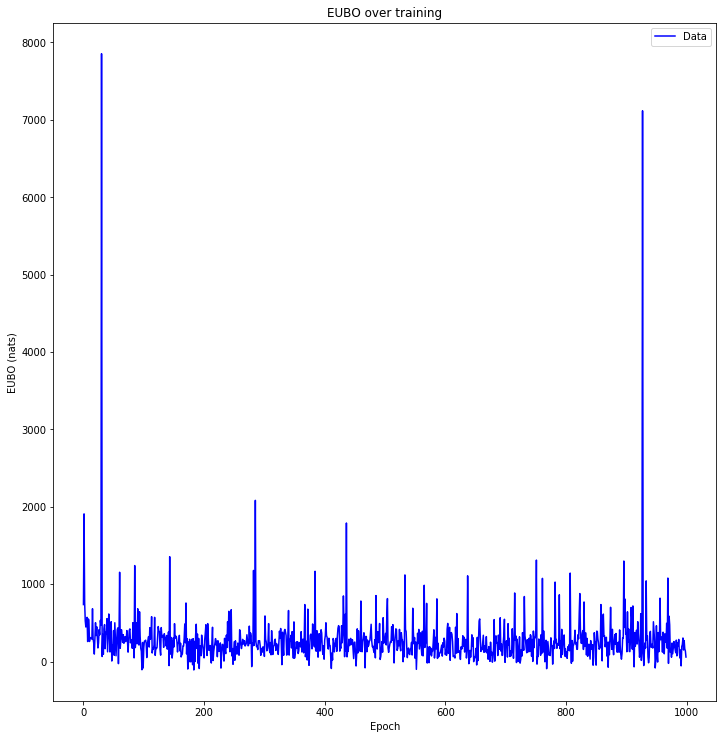

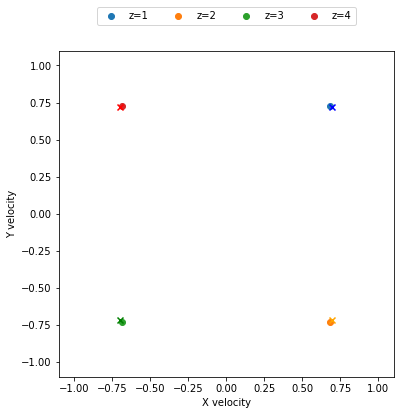

In [17]:
modal_directions = torch.zeros(num_series, K, 2)

for s in range(num_series):
    trajectory, displacements, data = generate_trajectory_trace(s)
    init_proposal = combinators.HyperPopulation(bouncing_ball.init_bouncing_ball, num_particles,
                                                trainable=variational_init_params)
    bouncing_ball_proposal = importance.smc(bouncing_ball_step, num_particles, lambda: range(T), initializer=init_proposal)
    
    importance_sampler = combinators.score_under_proposal(bouncing_ball_smc, bouncing_ball_proposal)
    
    inference, trained_params, eubos = importance.variational_importance(
        importance_sampler, 1000, data,
        use_cuda=False, lr=1e-2, inclusive_kl=True,
        patience=200,
    )
    trained_params = init_proposal.args_vardict()
    utils.plot_evidence_bounds(eubos, False)
    
    init_posterior = combinators.PrimitiveCall(bouncing_ball.init_bouncing_ball,
                                               hyper=trained_params)
    bouncing_ball_posterior = combinators.Reduce(bouncing_ball_step, lambda: range(T), initializer=init_posterior)
    _, inference, _ = bouncing_ball_posterior.simulate()
    inferred_trajectory = accumulate_trajectory(inference)
    
    positions = torch.stack([inferred_trajectory[:, t+1] for t in range(T)], dim=1).mean(dim=0).cpu().detach()
    displacements = torch.stack([inference['Reduce(bouncing_ball_step)/%d/bouncing_ball_step/displacement_%d' % (t, t+1)].value for t in range(T)], dim=1).mean(dim=0).cpu().detach()
    step_numbers = torch.stack((torch.arange(T), torch.arange(T) + 1), dim=-1)
    velocity_srcs = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements), displacements[:-1]), dim=1)
    velocity_dests = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements) + 1, displacements[1:]), dim=1)
    velocity_steps = torch.stack((velocity_srcs, velocity_dests), dim=1)
    
    graph_position_trajectory(positions, T, s)
    graph_displacement_trajectories(velocity_steps, displacements, T, s)
    
    alpha = torch.tensor(trained_params['directions']['angle']['concentration1']).mean(dim=0)
    beta = torch.tensor(trained_params['directions']['angle']['concentration0']).mean(dim=0)
    mean_angle = torch.distributions.Beta(alpha, beta).mean  * np.pi/2
    modal_directions[s] = bouncing_ball.reflect_directions(mean_angle)
    mean_angle = inference['init_bouncing_ball/directions__angle'].value.mean(dim=0).detach().cpu() * np.pi/2
    final_mus[s] = bouncing_ball.reflect_directions(mean_angle).numpy()
    final_covs[s] = inference['init_bouncing_ball/directions__scale'].value.mean(dim=0).detach().cpu().numpy()
    for k in range(K):
        As_pred[s][k] = inference['init_bouncing_ball/A_%d' % (k+1)].value.mean(dim=0).detach().cpu().numpy()
    
    plt.close('all')

graph_velocity_frequencies(modal_directions.detach().numpy())

In [18]:
import bouncing_ball_plots

In [19]:
fs = 3 ## figure size
vmax = 0.3 ## cmap maximum value, to make off-diagonal elements more visible
width_space = 0.05 # space between figures
height_space = 0.05 # space between figures
cov_flag = False # plot the covariances or not
legend_flag = False # plot the legend bar or not
save_flag = True ## save or not

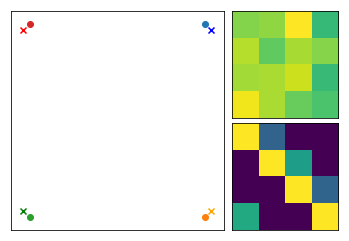

In [20]:
## plot method 1
bouncing_ball_plots.plot_circle_transition(init_v, final_mus, final_covs,
                                           As_pred, As_true, K, fs, vmax, width_space, height_space, cov_flag, legend_flag, save_flag)

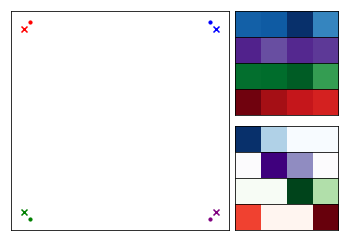

In [21]:
## plot method 2
bouncing_ball_plots.plot_circle_transition_colorcode(init_v, final_mus, final_covs, As_pred, As_true, K, fs, vmax, width_space, height_space, cov_flag, legend_flag, save_flag)

In [22]:
def plot_circle_transition_colorcode(init_v, final_mus, final_covs, As_pred, As_true, K, fs, vmax, width_space, height_space, cov_flag, legend_flag, save_flag):

    As_infer = As_pred / As_pred.sum(-1)[:, :, None]
    As_infer = As_infer.mean(0)
    As_true_ave = As_true.mean(0)

    fig = plt.figure(figsize=(fs*1.5 + width_space,fs + height_space))
    gs1 = gridspec.GridSpec(1, 1)
    # , width_ratios=[2,1], height_ratios=[1,1]
    gs1.update(left=0.0, bottom=0.0, right=(2/3), top=1.0, wspace=width_space, hspace=height_space)
    ax1 = fig.add_subplot(gs1[0])

    # ax3 = fig.add_subplot(gs[1, 1])
    ax1.set_xticks([])
    ax1.set_yticks([])

    gs2 = gridspec.GridSpec(4, 1)
    gs2.update(left=2/3 + (1/3)*width_space, bottom=0.5+(1/2)*width_space, right=1.0, top=1.0, wspace=0, hspace=0)
    ax2 = fig.add_subplot(gs2[0, 0])
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax3 = fig.add_subplot(gs2[1, 0])
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax4 = fig.add_subplot(gs2[2, 0])
    ax4.set_xticks([])
    ax4.set_yticks([])
    ax5 = fig.add_subplot(gs2[3, 0])
    ax5.set_xticks([])
    ax5.set_yticks([])

    gs3 = gridspec.GridSpec(4, 1)
    gs3.update(left=2/3 + (1/3)*width_space, bottom=0.0, right=1.0, top=0.5 - (1/2)*width_space, wspace=0, hspace=0)
    ax6 = fig.add_subplot(gs3[0, 0])
    ax6.set_xticks([])
    ax6.set_yticks([])
    ax7 = fig.add_subplot(gs3[1, 0])
    ax7.set_xticks([])
    ax7.set_yticks([])
    ax8 = fig.add_subplot(gs3[2, 0])
    ax8.set_xticks([])
    ax8.set_yticks([])
    ax9 = fig.add_subplot(gs3[3, 0])
    ax9.set_xticks([])
    ax9.set_yticks([])
    markersize = 10.0
    colors = ['b', 'Purple', 'g', 'r']
    ## plot left one
    ax1.scatter(init_v[:,0], init_v[:,1], s=markersize, color=colors[0], label='z=1')
    ax1.scatter(init_v[:,0], -init_v[:,1], s=markersize, color=colors[1], label='z=2')
    ax1.scatter(-init_v[:,0], -init_v[:,1], s=markersize, color=colors[2], label='z=3')
    ax1.scatter(-init_v[:,0], init_v[:,1], s=markersize, color=colors[3], label='z=4')

    for k in range(K):
        ax1.scatter(final_mus[:,k,0], final_mus[:,k,1], c=colors[k], marker='x')
    if cov_flag:
        for k in range(K):
            for s in range(num_series):
                plot_cov_ellipse(cov=final_covs[s, k, :, :], pos=final_mus[s, k, :], nstd=0.3, ax=ax1, alpha=0.3)
    #    ax1.set_xlabel('x velocity')
    #    ax1.set_ylabel('y velocity')
    if legend_flag:
        ax1.legend(loc='upper center', bbox_to_anchor=(0.75, 1.15), ncol=4)

    ax2.imshow(As_infer[None, 0,:], cmap='Blues', vmin=0, vmax=vmax)
    ax3.imshow(As_infer[None, 1,:], cmap='Purples', vmin=0, vmax=vmax)
    ax4.imshow(As_infer[None, 2,:], cmap='Greens', vmin=0, vmax=vmax)
    ax5.imshow(As_infer[None, 3,:], cmap='Reds', vmin=0, vmax=vmax)

    ax6.imshow(As_true_ave[None, 0,:], cmap='Blues', vmin=0, vmax=vmax)
    ax7.imshow(As_true_ave[None, 1,:], cmap='Purples', vmin=0, vmax=vmax)
    ax8.imshow(As_true_ave[None, 2,:], cmap='Greens', vmin=0, vmax=vmax)
    ax9.imshow(As_true_ave[None, 3,:], cmap='Reds', vmin=0, vmax=vmax)

    if save_flag:
        fig.savefig('combinator_results.pdf', dpi=600, bbox_inches='tight')
        fig.savefig('combinator_results.svg', dpi=600, bbox_inches='tight')
        fig.savefig('combinator_results.png', dpi=600, bbox_inches='tight')

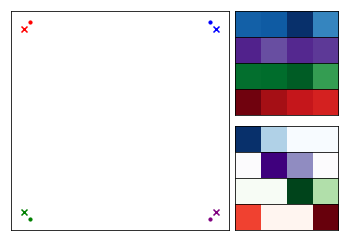

In [23]:
## plot method 2
plot_circle_transition_colorcode(init_v, final_mus, final_covs, As_pred, As_true, K, fs, vmax, width_space, height_space, cov_flag, legend_flag, save_flag)